In [2]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from monai.networks.layers import Reshape
from monai.visualize import matshow3d

In [3]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        self.linear = nn.Linear(100, 256*8*8*4)
        self.reshape = Reshape(256, 8, 8, 4)

        self.net = nn.Sequential(
            self._block(256, 128, 4, 2, 1),
            self._block(128, 64, 4, 2, 1),
            self._block(64, 32, 4, 2, 1),
            self._block(32, 16, (4,4,3), (2,2,1), 1),
            self._block(16, 1, (4,4,3), (2,2,1), 1),
            nn.Tanh(),
        )

    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.ConvTranspose3d(
                in_channels,
                out_channels,
                kernel_size,
                stride,
                padding,
                bias=False,
            ),
            nn.BatchNorm3d(out_channels),
            nn.ReLU(),
        )

    def forward(self, x):
        x = self.linear(x)
        x = self.reshape(x)
        x = self.net(x)
        return x

In [4]:
generator = Generator()
generator.load_state_dict(torch.load('/data2/etude/micorl/WGAN/models/checkpoint_04-12-2023_16:48.pt')['generator'])

<All keys matched successfully>

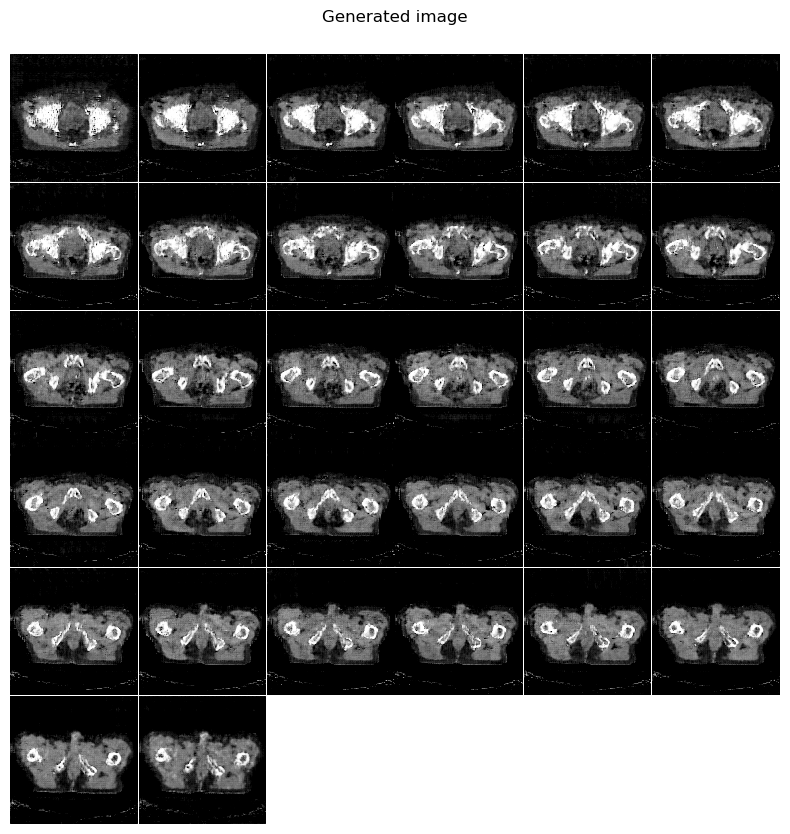

In [5]:
noise = torch.randn(1, 100)
with torch.no_grad():
    fake = generator(noise)
    fig = plt.figure(figsize=(15,15))
    matshow3d(volume=fake,
            fig=fig,
            title="Generated image",
            every_n=1,
            frame_dim=-1,
            cmap="gray")

torch.Size([1, 256, 256, 32])


(<Figure size 1000x1000 with 1 Axes>,
 array([[nan, nan, nan, ..., nan, nan, nan],
        [nan,  0.,  0., ...,  0.,  0., nan],
        [nan,  0.,  0., ...,  0.,  0., nan],
        ...,
        [nan,  0.,  0., ..., nan, nan, nan],
        [nan,  0.,  0., ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]], dtype=float32))

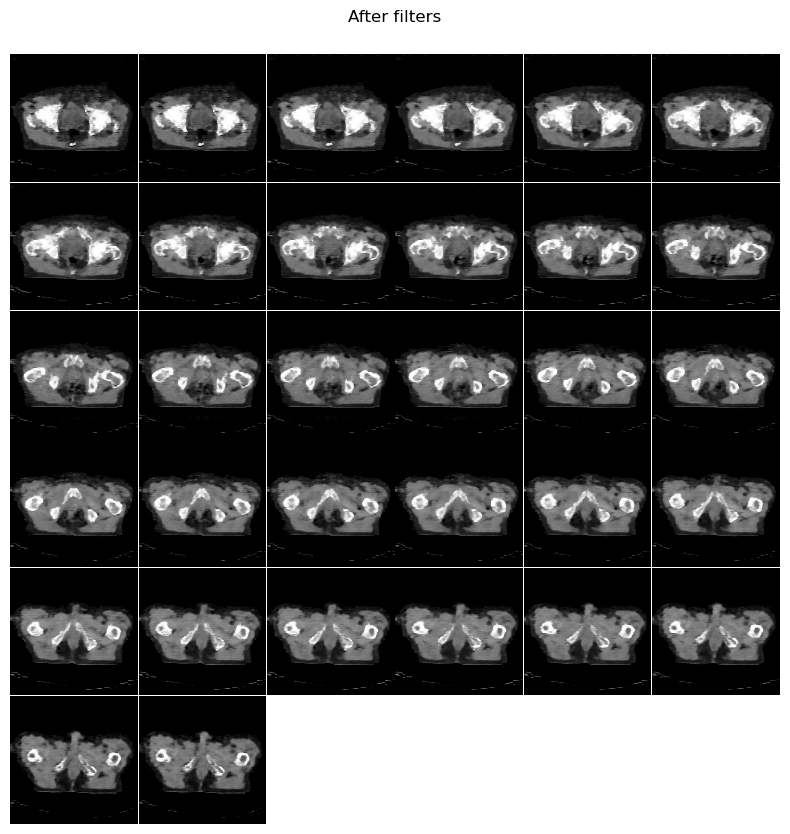

In [30]:
from kornia.filters import *
from kornia.morphology import *

image = fake[0]

# output = box_blur(image, (4,4))
# output = gaussian_blur2d(image, (5,5), (1.5,1.5))
output = median_blur(image, (5,5))

# output = dilation(output, torch.ones(3,3))
# output = erosion(output, torch.ones(4,4))
# output = opening(output, torch.ones(5,5))
output = closing(output, torch.ones(3,3))
print(output.shape)

fig = plt.figure(figsize=(15,15))
matshow3d(volume=output[0],
          fig=fig,
          title="After filters",
          every_n=1,
          frame_dim=-1,
          cmap="gray",
        )

(256, 256, 32)


(<Figure size 1000x1000 with 1 Axes>,
 array([[       nan,        nan,        nan, ...,        nan,        nan,
                nan],
        [       nan, 0.00365812, 0.00451141, ..., 0.00021502, 0.00021502,
                nan],
        [       nan, 0.0041072 , 0.0049605 , ..., 0.00021502, 0.00021502,
                nan],
        ...,
        [       nan, 0.00548961, 0.00548961, ...,        nan,        nan,
                nan],
        [       nan, 0.00548961, 0.00548961, ...,        nan,        nan,
                nan],
        [       nan,        nan,        nan, ...,        nan,        nan,
                nan]], dtype=float32))

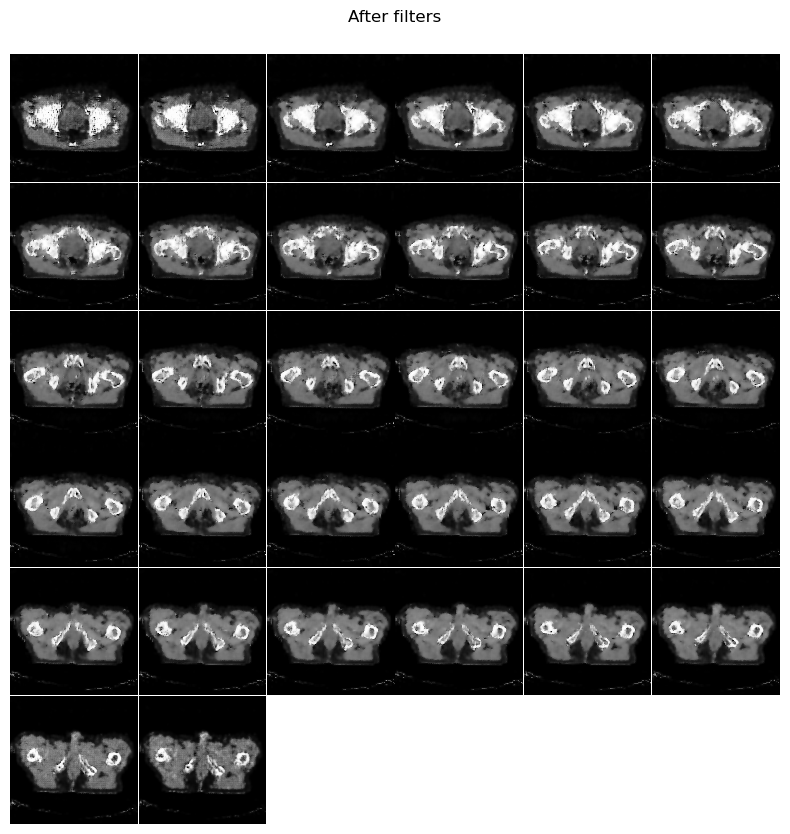

In [36]:
from scipy.signal import wiener

img = fake[0][0].numpy()
print(img.shape)
filtered_img = wiener(img, (5,5,5))

fig = plt.figure(figsize=(15,15))
matshow3d(volume=filtered_img,
          fig=fig,
          title="After filters",
          every_n=1,
          frame_dim=-1,
          cmap="gray",
        )

In [7]:
# from monai.data import NibabelWriter, MetaTensor

# m = MetaTensor(fake)
# writer = NibabelWriter()
# writer.set_data_array(m.get_array()[0][0], channel_dim=None)
# writer.write('./test.nii.gz', verbose=True)